# Sophisticated inference

This notebook demonstrates tree searching policies.

In [1]:
%load_ext autoreload
%autoreload 2

from pymdp.jax.envs.generalized_tmaze import (
    GeneralizedTMazeEnv, parse_maze, render 
)
from pymdp.jax.envs.rollout import rollout
from pymdp.jax.agent import Agent

import numpy as np 
import jax.random as jr 
import jax.numpy as jnp
import jax.tree_util as jtu 

[[0], [1], [2]]


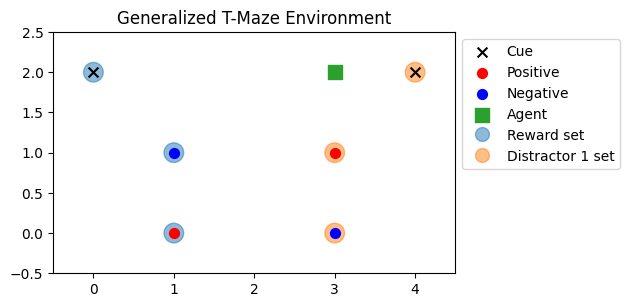

In [2]:
def get_maze_matrix(small=False):
    if small:
        M = np.zeros((3, 5))

        # Set the reward locations
        M[0,1] = 4
        M[1,1] = 5
        M[1,3] = 7
        M[0,3] = 8

        # Set the cue locations
        M[2,0] = 3
        M[2,4] = 6

        # Set the initial position
        M[2,3] = 1
    else:

        M = np.zeros((5, 5))

        # Set the reward locations
        M[0,1] = 4
        M[1,1] = 5
        M[1,3] = 7
        M[0,3] = 8
        M[4,1] = 10
        M[4,3] = 11

        # Set the cue locations
        M[2,0] = 3
        M[2,4] = 6
        M[3,2] = 9

        # Set the initial position
        M[2,2] = 1
    return M

M = get_maze_matrix(small=True)
env_info = parse_maze(M)
tmaze_env = GeneralizedTMazeEnv(env_info)
_ = render(env_info, tmaze_env)

In [3]:
A = [a.copy() for a in tmaze_env.params["A"]]
B = [b.copy() for b in tmaze_env.params["B"]]
A_dependencies = tmaze_env.dependencies["A"]
B_dependencies = tmaze_env.dependencies["B"]

# [position], [cue], [reward]
C = [jnp.zeros(a.shape[:2]) for a in A]

rewarding_modality = 2 + env_info["num_cues"]
#rewarding_modality = -1

C[rewarding_modality] = C[rewarding_modality].at[:,1].set(2.0)
C[rewarding_modality] = C[rewarding_modality].at[:,2].set(-3.0)

D = [jnp.ones(b.shape[:2]) for b in B]
D[0] = tmaze_env.params["D"][0].copy()

agent = Agent(
    A, B, C, D, 
    None, None, None, 
    policy_len=1,
    A_dependencies=A_dependencies, 
    B_dependencies=B_dependencies,
    apply_batch=False
)

In [4]:
from jax import random as jr

key = jr.PRNGKey(0)

In [5]:
keys = jr.split(key, 2)
key = keys[0]
obs, tmaze_env = tmaze_env.step(keys[1:])

In [6]:
print(obs)

[Array([[13]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


In [7]:
qs = agent.infer_states(
    observations=obs,
    past_actions=None,
    empirical_prior=agent.D,
    qs_hist=None,
)

In [8]:
print(qs)

[Array([[[4.930398e-32, 0.000000e+00, 4.930398e-32, 0.000000e+00,
         4.930398e-32, 4.930398e-32, 0.000000e+00, 4.930398e-32,
         0.000000e+00, 4.930398e-32, 0.000000e+00, 4.930398e-32,
         4.930398e-32, 1.000000e+00, 0.000000e+00]]], dtype=float32), Array([[[0.5, 0.5]]], dtype=float32), Array([[[0.5, 0.5]]], dtype=float32)]


In [9]:
print(agent.policies)

[[[0 0 0]]

 [[1 0 0]]

 [[2 0 0]]

 [[3 0 0]]]


In [10]:
from pymdp.jax.planning import tree_search

tree = tree_search(agent, qs, 1)

In [11]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_plan_tree(
    tree,
    font_size=12,
):
    root_node = tree.root()
    print(root_node["n"])

    colormap = plt.cm.Blues
    colormap_policy = plt.cm.Reds

    # create graph
    count = 0
    G = nx.Graph()
    to_visit = [(root_node, 0)]
    labels = {}
    colors = []

    G.add_node(count)
    labels[0] = ""
    colors.append((0.0, 0.0, 0.0, 1.0))
    count += 1

    # visit children
    while len(to_visit) > 0:
        node, id = to_visit.pop()
        for child in node["children"]:
            G.add_node(count)
            G.add_edge(id, count)

            cm = colormap
            if "policy" in child.keys():
                labels[count] = child["policy"][0]
                cm = colormap_policy
            elif "observation" in child.keys():
                o = child["observation"]
                labels[count] = str(o[0][0])
            else:
                labels[count] = ""

            r, g, b, a = cm(child.get("prob", 0))
            a *= 0.5
            colors.append((r, g, b, a))

            to_visit.append((child, count))
            count += 1.0

    # from networkx.drawing.nx_pydot import graphviz_layout

    # pos = graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        with_labels=True,
        font_size=font_size,
        labels=labels,
        node_color=colors,
    )

0


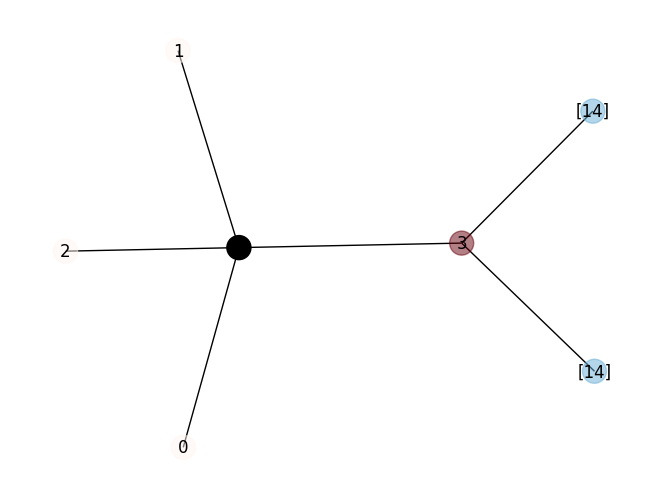

In [12]:
plot_plan_tree(tree)

0


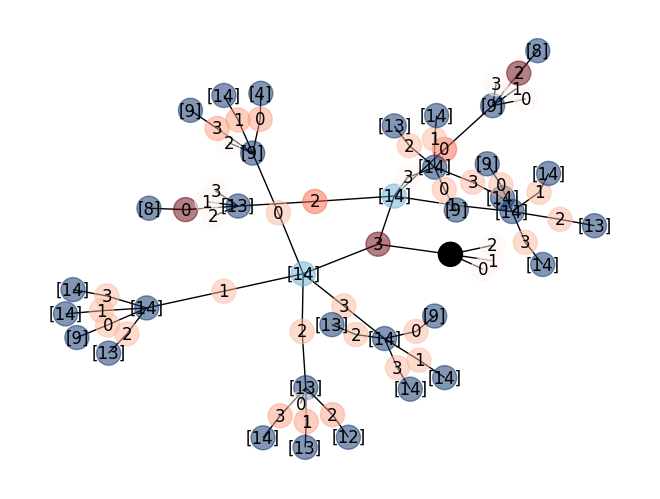

In [13]:
tree = tree_search(agent, qs, 3, entropy_prune_threshold=0.0)
plot_plan_tree(tree)